# Imports

In [1]:
from glob import glob
import h5py, os, copy
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.stats.stats import pearsonr
import pysptools.eea as eea #endmembers extraction algorithms
import pysptools.abundance_maps as amap
import pandas as pd
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
from earthpy.spatial import bytescale
import sys

from neon_helper_functions import *

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Import Hyperspectral

In [3]:
# Import hyp data into dict with tile number as key
ONAQ_hyp_refl=glob(os.path.join('data','NEON','*ONAQ*','*DP3*'))

# File import is scalable if multiple tiles are available
ONAQ_data={}
for file in ONAQ_hyp_refl:
    data,metadata=read_neon_reflh5(file)
    data_clean,metadata_clean = clean_neon_refl_data(
    data,metadata)
    print('Tile Key:',os.path.basename(file)[18:32])
    ONAQ_data[os.path.basename(file)[18:32]]={
        'reflectance':data_clean,
        'metadata':metadata_clean}
print('Raw Data Dimensions:',data.shape)
print('Cleaned Data Dimensions:',data_clean.shape)

Tile Key: 374000_4449000
Tile Key: 378000_4452000
Raw Data Dimensions: (1000, 1000, 426)
Cleaned Data Dimensions: (1000, 1000, 360)


# Import spectral signature

In [4]:
# Download data hosted on figshare
et.data.get_data(
    url='https://ndownloader.figshare.com/files/23262782')
et.data.get_data(
    url='https://ndownloader.figshare.com/files/23262785')


'C:\\Users\\17205\\earth-analytics\\data\\earthpy-downloads\\s07_AV14_Cheatgrass_ANP92-11A_BECKa_AREF'

In [5]:
AV_spect_lib_dir=glob(os.path.join('data','earthpy-downloads','*AV14*'))
AV_spect_sig={}
for dirs in AV_spect_lib_dir:
    error_bar=sorted(glob(os.path.join(dirs,'*errorbar*')))
    resolution_file=sorted(glob(os.path.join(dirs,'*Resolution*')))
    if not len(error_bar) == 0:
        os.remove(error_bar[0])
    if not len(resolution_file) == 0:
        os.remove(resolution_file[0])
    txt_files=sorted(glob(os.path.join(dirs,'*txt*')))
    object_name=os.path.basename(txt_files[0]).split('_')[2]
    AV_spect_sig[object_name]= {
        'Resolution':np.loadtxt(txt_files[0],skiprows=1),
        'Wavelength':np.loadtxt(txt_files[1],skiprows=1)}
for key in AV_spect_sig.keys():
    print('Spectral signatures available for', key)

Spectral signatures available for Cheatgrass
Spectral signatures available for Sagebrush


In [6]:
# Clean spectral library bad reflectance values
cheatgrass_res,cheatgrass_wave=clean_spectral_array(
    object_spect_dict=AV_spect_sig['Cheatgrass'])
sagebrush_res,sagebrush_wave=clean_spectral_array(
    object_spect_dict=AV_spect_sig['Sagebrush'])

In [7]:
# Interpolate spectral library data to match hyperspectral dimension
interp_res_sagebrush = np.interp(np.array(
    ONAQ_data['378000_4452000']['metadata']['wavelength']),
    sagebrush_wave,
    sagebrush_res) 
interp_res_sagebrush
interp_res_cheatgrass = np.interp(
    np.array(ONAQ_data['378000_4452000']['metadata']['wavelength']),
    cheatgrass_wave,
    cheatgrass_res)

# Plot Pure Spectral signatures from USGS Spectral Library

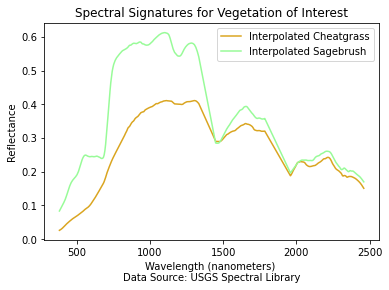

**************************************************
These spectral signatures are 86 percent similar.


In [8]:
# Plot spectral signatures from library
fig, (ax) = plt.subplots()
ax.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
        interp_res_cheatgrass, label='Interpolated Cheatgrass',
        color='goldenrod')
ax.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
        interp_res_sagebrush, label='Interpolated Sagebrush',
       color='palegreen')
ax.set_xlabel('Wavelength (nanometers) \n'
              'Data Source: USGS Spectral Library',
               fontsize=10)
ax.set_title('Spectral Signatures for Vegetation of Interest')

ax.set_ylabel('Reflectance')
plt.legend()
plt.show()
print('**************************************************')
print('These spectral signatures are',
      int(pearsonr(interp_res_cheatgrass,interp_res_sagebrush)[0]*100),
      'percent similar.')

# Create Objects for Endmember Extraction and Abundance Maps

In [9]:
ee = eea.NFINDR()
U=ee.extract(ONAQ_data['378000_4452000']['reflectance'],7,maxit=10,
               normalize=False,ATGP_init=True)

In [10]:
am = amap.FCLS() #define am object using the amap 
amaps = am.map(ONAQ_data['378000_4452000']['reflectance'],
               U,normalize=False) #create abundance maps for the HSI cubems

## Which Endmember is most likely Cheatgrass? Which one is sage?

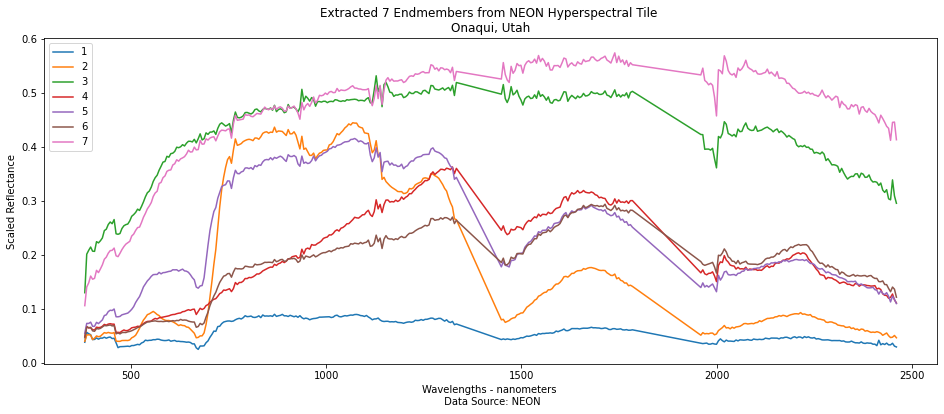

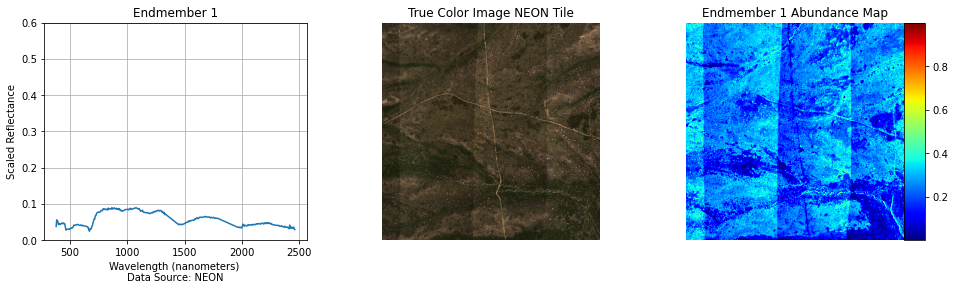

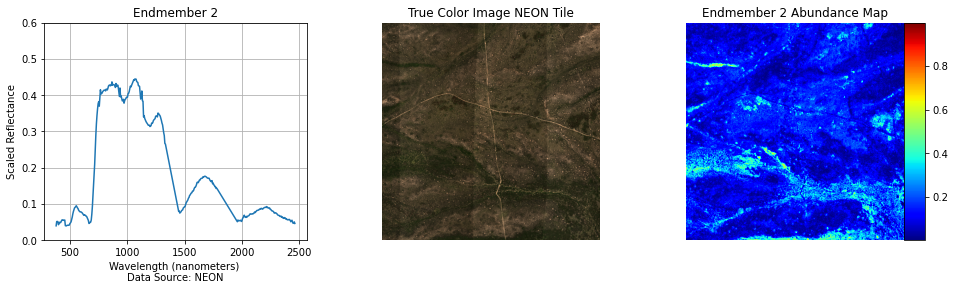

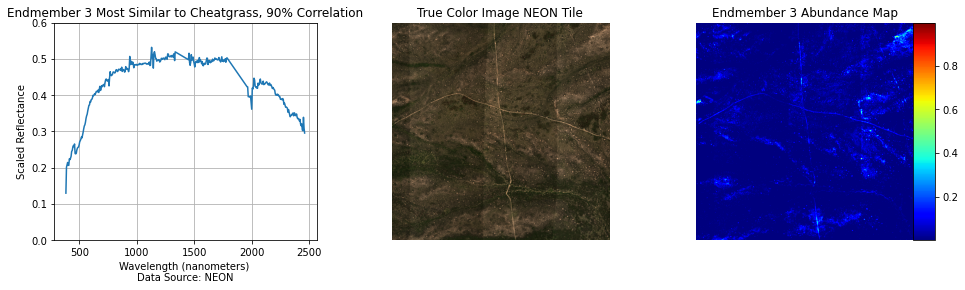

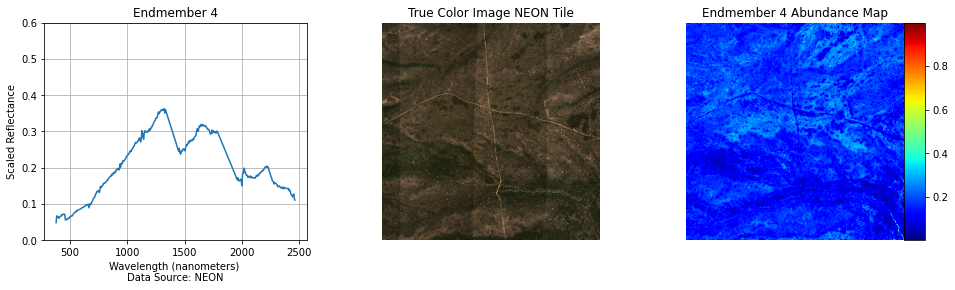

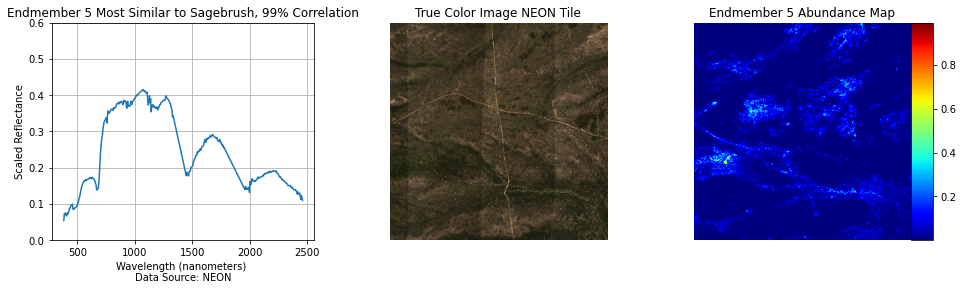

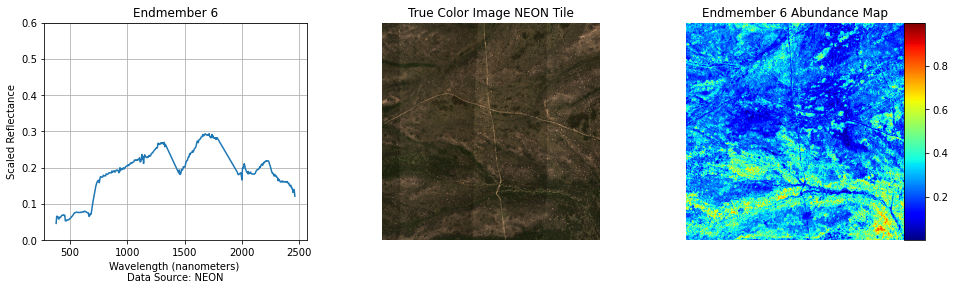

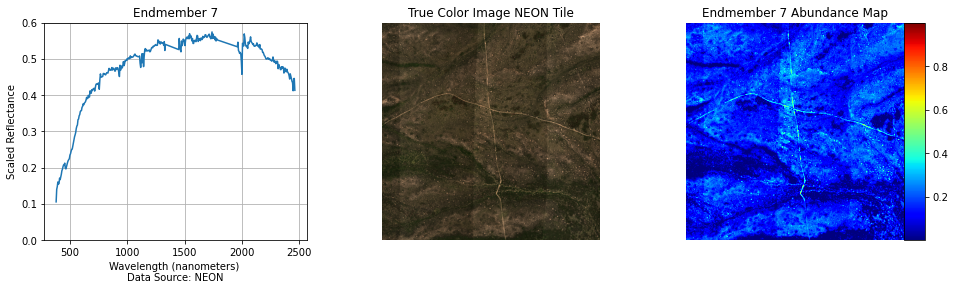

In [14]:
coefficient_sagebrush=[]
coefficient_cheatgrass=[]
for i in range(0,U.shape[0]):
    coefficient_sagebrush.append(pearsonr(
        interp_res_sagebrush,U[i])[0])
    coefficient_cheatgrass.append(pearsonr(
        interp_res_cheatgrass,U[i])[0])
closest_correl_sage=np.array(coefficient_sagebrush).max()
closest_correl_cheat=np.array(coefficient_cheatgrass).max()

plt.figure(figsize=(16,6))
plt.xlabel('Wavelengths - nanometers \n Data Source: NEON')
plt.ylabel('Scaled Reflectance')
n_em=0
for endmember in U:
    n_em+=1
    plt.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
             endmember,
             label=n_em)   
plt.legend()
plt.title(f'Extracted {n_em} Endmembers from NEON Hyperspectral Tile \nOnaqui, Utah')

plt.show()

n_em=0
for i,em in enumerate(U):
    n_em+=1
    fig = plt.figure(figsize=(16,4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])     
    ax0 = plt.subplot(gs[0])
    p0 = ax0.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'], em)
    if (pearsonr(interp_res_sagebrush,em)[0]) == closest_correl_sage:
        plt.title(
            f'Endmember {n_em} Most Similar to Sagebrush, {int(closest_correl_sage*100)}% Correlation')
    elif (pearsonr(interp_res_cheatgrass,em)[0]) == closest_correl_cheat:
        plt.title(
            f'Endmember {n_em} Most Similar to Cheatgrass, {int(closest_correl_cheat*100)}% Correlation')
    else:
        plt.title(f'Endmember {n_em}')
    ax0.grid(True)
    ax0.set_ylim(0,0.6)
    ax0.set_xlabel('Wavelength (nanometers) \n'
              'Data Source: NEON',
               fontsize=10)
    ax0.set_ylabel('Scaled Reflectance',
               fontsize=10)

    ax1 = plt.subplot(gs[1])
    ax1.set_axis_off()
    im1 = ax1.imshow(bytescale(ONAQ_data['378000_4452000']['reflectance'][:,:,[54, 34, 22]]))
    plt.title('True Color Image NEON Tile')
    

    ax2 = plt.subplot(gs[2])
    im2 = ax2.imshow(amaps[:,:,i],cmap='jet')
    ax2.set_axis_off()
    plt.title(f'Endmember {n_em} Abundance Map')
    

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="10%", pad=0.001)

    plt.colorbar(im2, cax=cax)
    plt.show()


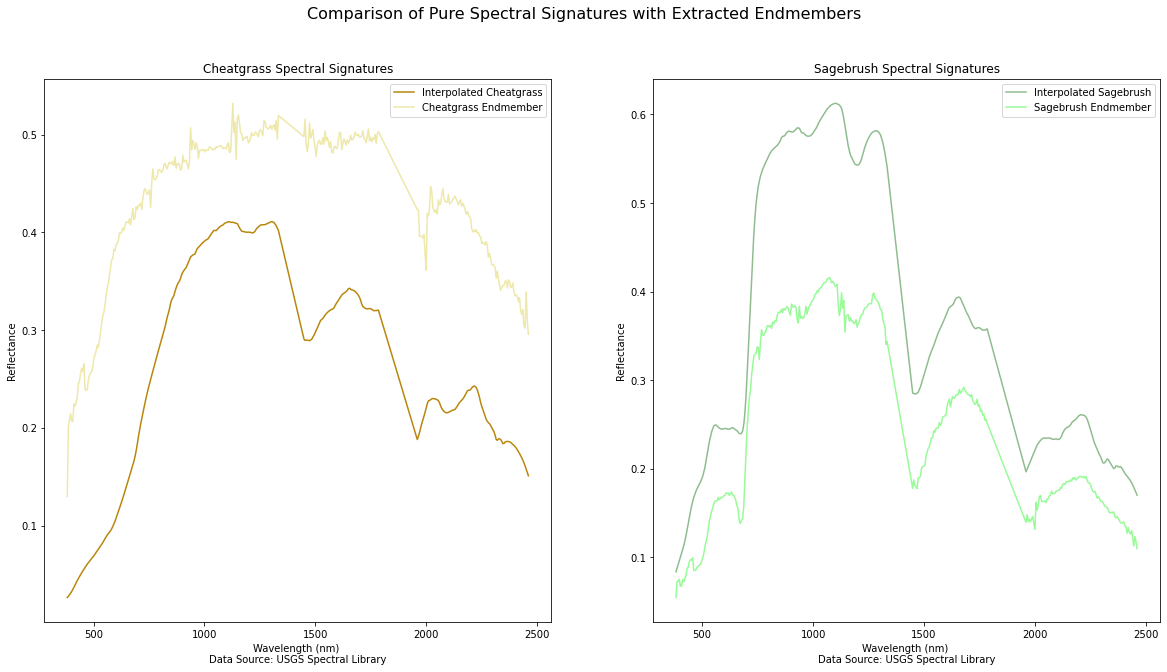

In [12]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(20,10))
plt.suptitle('Comparison of Pure Spectral Signatures with Extracted Endmembers',
            fontsize=16)
ax0.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
        interp_res_cheatgrass, label='Interpolated Cheatgrass',
        color='darkgoldenrod')
ax0.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
             U[2],color='palegoldenrod',
             label='Cheatgrass Endmember')
ax0.set_xlabel('Wavelength (nm) \n'
              'Data Source: USGS Spectral Library',
               fontsize=10)
ax0.set_ylabel('Reflectance')
ax0.set_title('Cheatgrass Spectral Signatures (90% Correlation)')
ax0.legend()

ax1.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
        interp_res_sagebrush, label='Interpolated Sagebrush',
       color='darkseagreen')
ax1.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
             U[4],
             label='Sagebrush Endmember',
             color='palegreen')
ax1.set_xlabel('Wavelength (nm) \n'
              'Data Source: USGS Spectral Library',
               fontsize=10)

ax1.set_ylabel('Reflectance')
ax1.set_title('Sagebrush Spectral Signatures (99% Correlation)')
ax1.legend()
plt.show()